In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

# import os
# if os.name == 'posix' :
#     plt.rc('font', family='AppleGothic')
# else :
#     plt.rc('font', family='Malgun Gothic')
    
plt.rc('axes', unicode_minus=False)

plt.rcParams['font.family'] = 'NanumGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

## 데이터 불러오기

In [2]:
user_df = pd.read_parquet('./votes/accounts_user.parquet')
user_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [3]:
userquestion_df = pd.read_parquet('./votes/accounts_userquestionrecord.parquet')
userquestion_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [4]:
userquestion_567_df = userquestion_df[(userquestion_df['created_at']>='2023-05-01') & (userquestion_df['created_at']<'2023-08-01')]

In [5]:
school_df = pd.read_parquet('./votes/accounts_school.parquet')
school_df.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


In [6]:
group_df = pd.read_parquet('./votes/accounts_group.parquet')
group_df.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [7]:
group_df.describe()

,id,grade,class_num,school_id
count,84515.000000,84515.000000,84515.000000,84515.000000
mean,42279.376087,2.113992,5.318606,3079.496468
std,24400.962630,0.754896,4.089901,1675.036093
min,1.000000,1.000000,0.000000,1.000000
25%,21147.500000,2.000000,2.000000,1752.000000
50%,42279.000000,2.000000,4.000000,3023.000000
75%,63411.500000,3.000000,7.000000,4620.000000
max,84546.000000,20.000000,41.000000,5965.000000


In [8]:
# 3학년 이상인 데이터 수
group_df[group_df['grade'] > 3]

,id,grade,class_num,school_id
32624,32644,4,10,4658
61622,61647,20,7,3867


In [9]:
# 0반 데이터 수 
group_df[group_df['class_num'] == 0]

,id,grade,class_num,school_id
62234,62259,2,0,4348
62626,62651,2,0,1820


In [10]:
# 20반 보다 큰 수 확인
group_df[group_df['class_num'] > 20]

,id,grade,class_num,school_id
70368,70394,1,41,736


- 이상치 제거
    - grade : 4학년, 20학년 제외
    - class_num : 0반, 41반 제외

In [11]:
# 이상치 제거 하기
group_df = group_df[(group_df['grade'] <= 3) & (group_df['class_num'] <= 20) & (group_df['class_num'] > 0) ]

---

## 데이터 전처리 (합치기, 추출하기 등)

### 10개 학교 데이터로 뽑기

In [12]:
# school_id, group_id 테이블 합치기
school_group_df = pd.merge(group_df, school_df, left_on='school_id', right_on='id', how='left')
school_group_df = school_group_df.drop(columns=['class_num', 'id_y'])
school_group_df = school_group_df.rename(columns={'id_x':'group_id'})
school_group_df.head()

,group_id,grade,school_id,address,student_count,school_type
0,1,1,1,NaN,NaN,NaN
1,8,3,1,NaN,NaN,NaN
2,9,3,1,NaN,NaN,NaN
3,10,2,1,NaN,NaN,NaN
4,11,2,1,NaN,NaN,NaN


In [13]:
user_group_df = user_df[['id', 'group_id']]
user_school_df = pd.merge(user_group_df, school_group_df, on='group_id', how='left')
user_school_df.head()

,id,group_id,grade,school_id,address,student_count,school_type
0,831956,NaN,NaN,NaN,NaN,NaN,NaN
1,831962,12.0,2.0,1.0,NaN,NaN,NaN
2,832151,1.0,1.0,1.0,NaN,NaN,NaN
3,832340,1.0,1.0,1.0,NaN,NaN,NaN
4,832520,12.0,2.0,1.0,NaN,NaN,NaN


In [14]:
# 결측치를 0으로 채워서 사라지지 않게 하기
user_school_fillna_df = user_school_df.copy()
user_school_fillna_df = user_school_fillna_df.fillna(0)

In [15]:
user_school_fillna_df.head()

,id,group_id,grade,school_id,address,student_count,school_type
0,831956,0.0,0.0,0.0,0,0.0,0
1,831962,12.0,2.0,1.0,0,0.0,0
2,832151,1.0,1.0,1.0,0,0.0,0
3,832340,1.0,1.0,1.0,0,0.0,0
4,832520,12.0,2.0,1.0,0,0.0,0


In [16]:
# 투표 기록 테이블에 학교 정보 합치기
userquestion_school_df = pd.merge(userquestion_df, user_school_fillna_df, left_on='user_id', right_on='id', how='left')
userquestion_school_df.head()

,id_x,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,id_y,group_id,grade,school_id,address,student_count,school_type
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H


In [17]:
# 필요없는 컬럼 삭제하기
userquestion_school_df = userquestion_school_df.drop(columns=['id_x','report_count', 'opened_times', 'id_y'])
userquestion_school_df.head()

,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,group_id,grade,school_id,address,student_count,school_type
0,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
1,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
2,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
3,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
4,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H


In [18]:
# 학교 수 확인해보기
userquestion_school_df['school_id'].nunique()

10

In [19]:
# 5~7월 데이터로만 추출
userquestion_school_567_df = userquestion_school_df[(userquestion_school_df['created_at']>= '2023-04-28')&(userquestion_school_df['created_at'] < '2023-05-26')]
userquestion_school_567_df.head()

,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,group_id,grade,school_id,address,student_count,school_type
0,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
1,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
2,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
3,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
4,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H


In [20]:
# 학교 수 확인해보기
userquestion_school_567_df['school_id'].nunique()

10

In [21]:
# 학교 리스트 담기
school_list = list(userquestion_school_567_df['school_id'].unique())
school_list

[271.0, 4516.0, 369.0, 352.0, 1478.0, 5520.0, 5491.0, 5372.0, 1719.0, 4426.0]

In [22]:
user_school_fillna_df.head()

,id,group_id,grade,school_id,address,student_count,school_type
0,831956,0.0,0.0,0.0,0,0.0,0
1,831962,12.0,2.0,1.0,0,0.0,0
2,832151,1.0,1.0,1.0,0,0.0,0
3,832340,1.0,1.0,1.0,0,0.0,0
4,832520,12.0,2.0,1.0,0,0.0,0


In [23]:
# 10개 학교의 학생 수 
user_school_10_df = user_school_fillna_df[user_school_fillna_df['school_id'].isin(school_list)]
user_school_10_df['id'].nunique()

5090

In [24]:
# 학생 user_id 리스트에 담기
user_id_list = list(user_school_10_df['id'].unique())

In [25]:
# 유저 수 확인해보기
userquestion_school_567_df['user_id'].nunique()

4703

### 10개 학교 학생들의 누적 회원가입 수 구하기

In [26]:
# 전체 user 데이터에서 학생들 user_id가 일치하는 것들만 남기기
user_target_df = user_df[user_df['id'].isin(user_id_list)]
user_target_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
396,838023,0,0,F,2456,"[855552, 861830, 859783, 850186, 868492, 85595...",1,2023-04-19 09:06:00.719792,[],[],N,0,1,0,115,233.0
633,838466,0,0,F,1680,"[876288, 869250, 873349, 867975, 878602, 11573...",1,2023-04-19 15:10:56.560337,[],[],N,0,1,0,244,321.0
756,838642,0,0,F,382,"[849928, 847375, 849938, 849946, 849436, 84943...",1,2023-04-20 00:11:00.962160,[],[],N,0,0,0,37,356.0
1252,839357,0,0,M,2299,"[855552, 857473, 861830, 866953, 867849, 86605...",1,2023-04-20 14:26:20.479856,[],[],N,0,1,0,52,519.0
1497,839670,0,0,F,643,"[871299, 850180, 850948, 849670, 851593, 84737...",0,2023-04-21 00:25:27.279382,[],[],N,0,1,0,24,603.0


In [27]:
# 연-월-일 컬럼 뽑기
user_target_df['year_month_day'] = user_target_df['created_at'].dt.strftime('%Y-%m-%d')
user_target_df.head()

/tmp/ipykernel_1078767/1907878019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_target_df['year_month_day'] = user_target_df['created_at'].dt.strftime('%Y-%m-%d')


,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id,year_month_day
396,838023,0,0,F,2456,"[855552, 861830, 859783, 850186, 868492, 85595...",1,2023-04-19 09:06:00.719792,[],[],N,0,1,0,115,233.0,2023-04-19
633,838466,0,0,F,1680,"[876288, 869250, 873349, 867975, 878602, 11573...",1,2023-04-19 15:10:56.560337,[],[],N,0,1,0,244,321.0,2023-04-19
756,838642,0,0,F,382,"[849928, 847375, 849938, 849946, 849436, 84943...",1,2023-04-20 00:11:00.962160,[],[],N,0,0,0,37,356.0,2023-04-20
1252,839357,0,0,M,2299,"[855552, 857473, 861830, 866953, 867849, 86605...",1,2023-04-20 14:26:20.479856,[],[],N,0,1,0,52,519.0,2023-04-20
1497,839670,0,0,F,643,"[871299, 850180, 850948, 849670, 851593, 84737...",0,2023-04-21 00:25:27.279382,[],[],N,0,1,0,24,603.0,2023-04-21


In [28]:
# 일별 회원가입 유저 수 구하기
user_count_df = user_target_df.groupby(['year_month_day'])['id'].nunique().reset_index(name='daily_user_cnt')
user_count_df.head()

,year_month_day,daily_user_cnt
0,2023-04-19,2
1,2023-04-20,2
2,2023-04-21,6
3,2023-04-22,4
4,2023-04-24,5


In [29]:
# 누적 회원 수 구하기
user_count_df['total_user'] = user_count_df['daily_user_cnt'].cumsum()
user_count_df.head()

,year_month_day,daily_user_cnt,total_user
0,2023-04-19,2,2
1,2023-04-20,2,4
2,2023-04-21,6,10
3,2023-04-22,4,14
4,2023-04-24,5,19


In [30]:
# 5월부터 확인해보기
user_count_df = user_count_df[user_count_df['year_month_day'] >= '2023-05-01']
user_count_df.head()

,year_month_day,daily_user_cnt,total_user
11,2023-05-01,43,446
12,2023-05-02,99,545
13,2023-05-03,389,934
14,2023-05-04,184,1118
15,2023-05-05,434,1552


---

### 일별 투표자 수 확인하기

In [31]:
userquestion_school_567_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1015471 entries, 0 to 1015470
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   status             1015471 non-null  object        
 1   created_at         1015471 non-null  datetime64[ns]
 2   chosen_user_id     1015471 non-null  int64         
 3   question_id        1015471 non-null  int64         
 4   user_id            1015471 non-null  int64         
 5   question_piece_id  1015471 non-null  int64         
 6   has_read           1015471 non-null  int64         
 7   answer_status      1015471 non-null  object        
 8   answer_updated_at  1015471 non-null  datetime64[ns]
 9   group_id           1015471 non-null  float64       
 10  grade              1015471 non-null  float64       
 11  school_id          1015471 non-null  float64       
 12  address            1015471 non-null  object        
 13  student_count      1015471 non-n

In [32]:
# 연-월-일 컬럼 만들기
userquestion_school_567_df['year_month_day'] = userquestion_school_567_df['created_at'].dt.strftime('%Y-%m-%d')

# 일별 투표자 수 구하기
daily_vote_user_cnt_df = userquestion_school_567_df.groupby(['year_month_day'])['user_id'].nunique().reset_index(name='daily_vote_user_cnt')
daily_vote_user_cnt_df.head()

/tmp/ipykernel_1078767/2783019631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userquestion_school_567_df['year_month_day'] = userquestion_school_567_df['created_at'].dt.strftime('%Y-%m-%d')


,year_month_day,daily_vote_user_cnt
0,2023-04-28,125
1,2023-04-29,221
2,2023-04-30,325
3,2023-05-01,325
4,2023-05-02,413


In [33]:
# user_count_df 와 합치기
user_count_df = pd.merge(user_count_df, daily_vote_user_cnt_df, on='year_month_day',how='left')
user_count_df.head()

,year_month_day,daily_user_cnt,total_user,daily_vote_user_cnt
0,2023-05-01,43,446,325.0
1,2023-05-02,99,545,413.0
2,2023-05-03,389,934,756.0
3,2023-05-04,184,1118,820.0
4,2023-05-05,434,1552,1248.0


In [34]:
# 투표율 구하기
user_count_df['vote_rate'] = user_count_df['daily_vote_user_cnt'] / user_count_df['total_user']
user_count_df.head()

,year_month_day,daily_user_cnt,total_user,daily_vote_user_cnt,vote_rate
0,2023-05-01,43,446,325.0,0.728700
1,2023-05-02,99,545,413.0,0.757798
2,2023-05-03,389,934,756.0,0.809422
3,2023-05-04,184,1118,820.0,0.733453
4,2023-05-05,434,1552,1248.0,0.804124


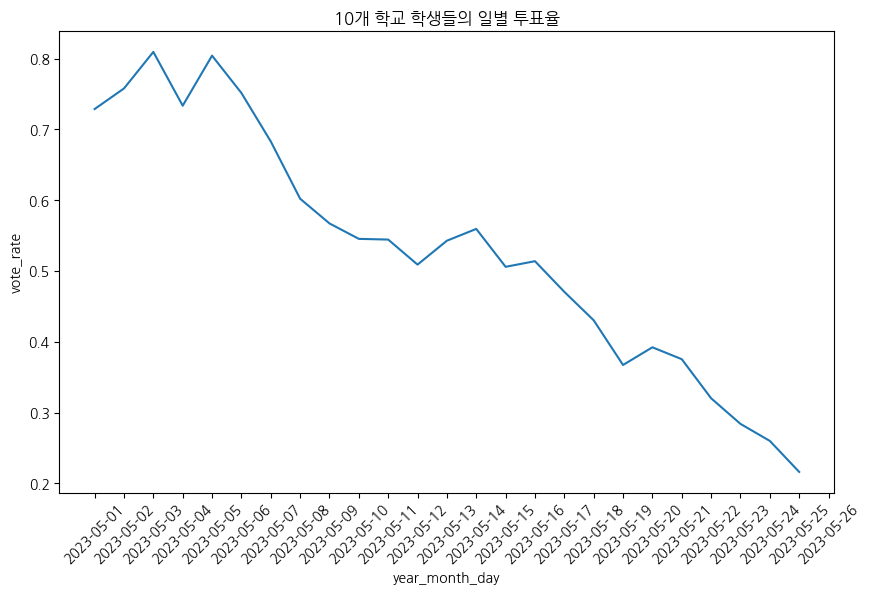

In [35]:
plt.figure(figsize=(10,6))
sns.lineplot(data=user_count_df,  x='year_month_day', y='vote_rate')
plt.title('10개 학교 학생들의 일별 투표율')
plt.xticks(rotation=45)
plt.show()

- 분모의 가입자는 계속 늘어남. 누적 가입 인원이기 때문에
- 투표율이 줄어드는 것은 어쨌든, 서비스에 지속적인 흥미를 느끼지 못하고 유저들이 앱에 들어왔으나 투표를 안하고 나갔거나 / 단발성으로 회원가입 후 한두번 투표 해보고 재방문을 안했다는 의미

---

## 재투표 리텐션 확인하기

In [36]:
# 유저별 투표일, 일별 투표 수 확인하기
vote_retention_df = userquestion_school_567_df.groupby(['user_id', 'year_month_day']).size().reset_index(name='count')
vote_retention_df.head()

,user_id,year_month_day,count
0,838023,2023-04-29,1
1,838023,2023-04-30,6
2,838023,2023-05-02,1
3,838023,2023-05-03,10
4,838023,2023-05-04,4


In [37]:
# 유저별 몇번째 투표일인지 나타내기
# 첫 번째 투표일을 1 으로 표시
vote_retention_df['visit_order'] = (
    vote_retention_df
    .groupby('user_id')
    .cumcount() + 1
)
vote_retention_df.head()

,user_id,year_month_day,count,visit_order
0,838023,2023-04-29,1,1
1,838023,2023-04-30,6,2
2,838023,2023-05-02,1,3
3,838023,2023-05-03,10,4
4,838023,2023-05-04,4,5


### 리텐션 차트 구하기

In [38]:
# 데이터 복사해놓기
retentiochart_df = vote_retention_df.copy()

# 투표한 첫째날 구하기
first_visit = retentiochart_df.groupby('user_id')['year_month_day'].min().reset_index()
first_visit.columns = ['user_id', 'first_day']
first_visit.head()

,user_id,first_day
0,838023,2023-04-29
1,838466,2023-05-02
2,838642,2023-04-28
3,839357,2023-04-29
4,840293,2023-05-03


In [39]:
# 원본 데이터와 합치기
retentiochart_df = pd.merge(retentiochart_df, first_visit, on='user_id')
retentiochart_df.head()

,user_id,year_month_day,count,visit_order,first_day
0,838023,2023-04-29,1,1,2023-04-29
1,838023,2023-04-30,6,2,2023-04-29
2,838023,2023-05-02,1,3,2023-04-29
3,838023,2023-05-03,10,4,2023-04-29
4,838023,2023-05-04,4,5,2023-04-29


In [40]:
# 각 row마다 Day N (투표 기준 몇번째 일자인지) 계산
retentiochart_df['day_number'] = (pd.to_datetime(retentiochart_df['year_month_day']) - pd.to_datetime(retentiochart_df['first_day'])).dt.days
retentiochart_df.head()

,user_id,year_month_day,count,visit_order,first_day,day_number
0,838023,2023-04-29,1,1,2023-04-29,0
1,838023,2023-04-30,6,2,2023-04-29,1
2,838023,2023-05-02,1,3,2023-04-29,3
3,838023,2023-05-03,10,4,2023-04-29,4
4,838023,2023-05-04,4,5,2023-04-29,5


In [41]:
# 코호트 기준: 첫 투표일 기준으로 그룹핑
retentiochart_df['cohort'] = retentiochart_df['first_day']
retentiochart_df.head()

,user_id,year_month_day,count,visit_order,first_day,day_number,cohort
0,838023,2023-04-29,1,1,2023-04-29,0,2023-04-29
1,838023,2023-04-30,6,2,2023-04-29,1,2023-04-29
2,838023,2023-05-02,1,3,2023-04-29,3,2023-04-29
3,838023,2023-05-03,10,4,2023-04-29,4,2023-04-29
4,838023,2023-05-04,4,5,2023-04-29,5,2023-04-29


In [42]:
# 코호트별로(첫 ) 각 Day에 방문한 유저 수 집계
retention = (
    retentiochart_df.groupby(['cohort', 'day_number'])['user_id']
    .nunique()
    .unstack(fill_value=0)
)
retention.head()

day_number,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
cohort,,,,,,,,,,,,,,,,,,,,,
2023-04-28,125,122,113,101,113,90,77,75,70,61,...,23,19,13,14,12,15,8,7,10,11
2023-04-29,99,98,85,89,83,67,63,64,51,45,...,11,10,11,8,7,5,2,6,2,0
2023-04-30,114,103,108,102,79,80,82,65,60,62,...,17,21,21,20,15,16,17,16,0,0
2023-05-01,36,31,30,23,26,20,23,21,16,11,...,8,6,6,6,2,6,5,0,0,0
2023-05-02,72,68,60,60,60,59,45,41,41,31,...,17,12,11,15,9,9,0,0,0,0


In [43]:
retention[[0]]

day_number,0
cohort,
2023-04-28,125
2023-04-29,99
2023-04-30,114
2023-05-01,36
2023-05-02,72
2023-05-03,383
2023-05-04,167
2023-05-05,436
2023-05-06,183


In [44]:
# 각 코호트의 Day 0 유저 수로 나눠 비율(%) 계산
cohort_sizes = retention[0]
retention_rate = retention.divide(cohort_sizes, axis=0) * 100  # %로
retention_rate = retention_rate.round(1)
retention_rate.head()

day_number,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
cohort,,,,,,,,,,,,,,,,,,,,,
2023-04-28,100.0,97.6,90.4,80.8,90.4,72.0,61.6,60.0,56.0,48.8,...,18.4,15.2,10.4,11.2,9.6,12.0,6.4,5.6,8.0,8.8
2023-04-29,100.0,99.0,85.9,89.9,83.8,67.7,63.6,64.6,51.5,45.5,...,11.1,10.1,11.1,8.1,7.1,5.1,2.0,6.1,2.0,0.0
2023-04-30,100.0,90.4,94.7,89.5,69.3,70.2,71.9,57.0,52.6,54.4,...,14.9,18.4,18.4,17.5,13.2,14.0,14.9,14.0,0.0,0.0
2023-05-01,100.0,86.1,83.3,63.9,72.2,55.6,63.9,58.3,44.4,30.6,...,22.2,16.7,16.7,16.7,5.6,16.7,13.9,0.0,0.0,0.0
2023-05-02,100.0,94.4,83.3,83.3,83.3,81.9,62.5,56.9,56.9,43.1,...,23.6,16.7,15.3,20.8,12.5,12.5,0.0,0.0,0.0,0.0


In [45]:
# 재투표율 리텐션 비율을 구한 데이터프레임의 제일 첫번째에 해당 cohort의 그룹 수를 넣어보기

# 유저 수 추출
user_cnt = retention[0]
# 데이터프레임으로 변환
user_cnt = user_cnt.to_frame(name='user_count')
# 재투표율 리텐션 비율을 구한 데이터프레임에 합치기
retention_with_usercount_df = pd.concat([user_cnt,retention_rate], axis=1)
retention_with_usercount_df.tail(30)

,user_count,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
cohort,,,,,,,,,,,,,,,,,,,,,
2023-04-28,125,100.0,97.6,90.4,80.8,90.4,72.0,61.6,60.0,56.0,...,18.4,15.2,10.4,11.2,9.6,12.0,6.4,5.6,8.0,8.8
2023-04-29,99,100.0,99.0,85.9,89.9,83.8,67.7,63.6,64.6,51.5,...,11.1,10.1,11.1,8.1,7.1,5.1,2.0,6.1,2.0,0.0
2023-04-30,114,100.0,90.4,94.7,89.5,69.3,70.2,71.9,57.0,52.6,...,14.9,18.4,18.4,17.5,13.2,14.0,14.9,14.0,0.0,0.0
2023-05-01,36,100.0,86.1,83.3,63.9,72.2,55.6,63.9,58.3,44.4,...,22.2,16.7,16.7,16.7,5.6,16.7,13.9,0.0,0.0,0.0
2023-05-02,72,100.0,94.4,83.3,83.3,83.3,81.9,62.5,56.9,56.9,...,23.6,16.7,15.3,20.8,12.5,12.5,0.0,0.0,0.0,0.0
2023-05-03,383,100.0,90.6,92.2,87.7,82.2,68.4,60.8,50.1,42.3,...,13.1,7.8,7.6,7.8,6.0,0.0,0.0,0.0,0.0,0.0
2023-05-04,167,100.0,92.8,90.4,83.8,63.5,55.7,49.7,41.9,33.5,...,9.0,7.2,6.6,5.4,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05,436,100.0,93.8,85.8,75.9,59.4,56.9,43.8,37.6,31.7,...,7.8,8.3,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-06,183,100.0,88.5,81.4,71.0,57.4,54.1,38.3,35.5,32.8,...,6.0,3.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 리텐션 차트의 기간은?

- 일단, cohort의 수가 너무 적으면 안됨
    - 기준은 중심극한정리 (Central Limit Theorem)
    - 표본 크기 n 이 충분히 크면, 어떤 분포에서 추출한 표본의 평균 분포는 정규분포에 가까워진다.
    - 통계 실무에서는 **표본 크기 n \geq 30**이면 “충분히 크다”고 보고, 평균이 정규분포를 따른다고 가정

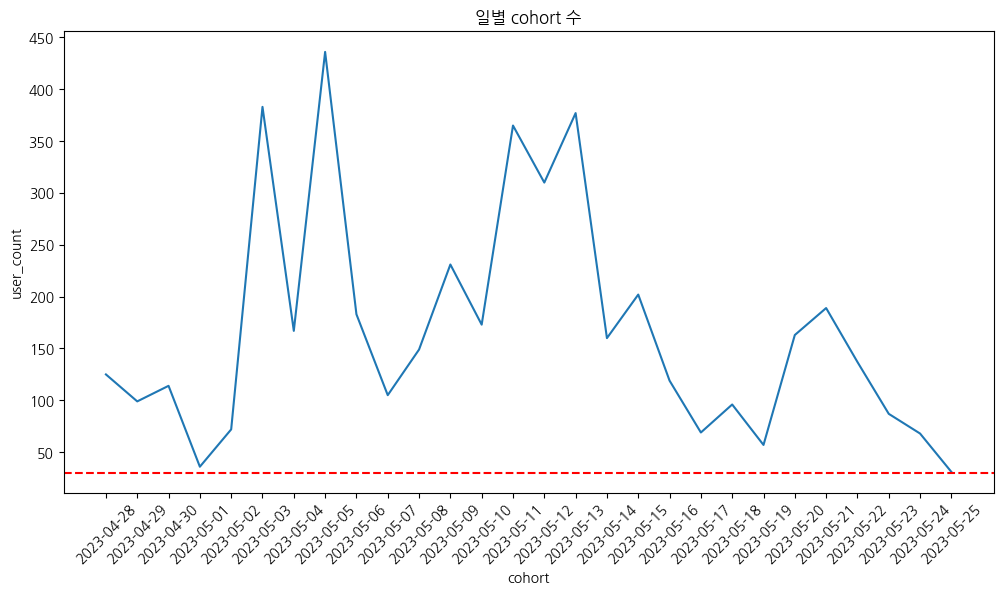

In [46]:
# 집단별 표본 크기 그래프로 그려보기

plt.figure(figsize=(12,6))
sns.lineplot(data=retention_with_usercount_df, x='cohort', y='user_count')
# y=30 기준선 추가 (점선)
plt.axhline(y=30, color='red', linestyle='--', linewidth=1.5, label='n = 30 기준선')
plt.title('일별 cohort 수')
plt.xticks(rotation=45)
plt.show()

In [47]:
retention_with_usercount_df[retention_with_usercount_df['user_count'] <= 30]

,user_count,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
cohort,,,,,,,,,,,,,,,,,,,,,


- 기간은 표본 크기가 30 이상인 4/28 ~ 5/25

In [48]:
retention_with_usercount_df[retention_with_usercount_df['user_count'] > 30]

,user_count,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
cohort,,,,,,,,,,,,,,,,,,,,,
2023-04-28,125,100.0,97.6,90.4,80.8,90.4,72.0,61.6,60.0,56.0,...,18.4,15.2,10.4,11.2,9.6,12.0,6.4,5.6,8.0,8.8
2023-04-29,99,100.0,99.0,85.9,89.9,83.8,67.7,63.6,64.6,51.5,...,11.1,10.1,11.1,8.1,7.1,5.1,2.0,6.1,2.0,0.0
2023-04-30,114,100.0,90.4,94.7,89.5,69.3,70.2,71.9,57.0,52.6,...,14.9,18.4,18.4,17.5,13.2,14.0,14.9,14.0,0.0,0.0
2023-05-01,36,100.0,86.1,83.3,63.9,72.2,55.6,63.9,58.3,44.4,...,22.2,16.7,16.7,16.7,5.6,16.7,13.9,0.0,0.0,0.0
2023-05-02,72,100.0,94.4,83.3,83.3,83.3,81.9,62.5,56.9,56.9,...,23.6,16.7,15.3,20.8,12.5,12.5,0.0,0.0,0.0,0.0
2023-05-03,383,100.0,90.6,92.2,87.7,82.2,68.4,60.8,50.1,42.3,...,13.1,7.8,7.6,7.8,6.0,0.0,0.0,0.0,0.0,0.0
2023-05-04,167,100.0,92.8,90.4,83.8,63.5,55.7,49.7,41.9,33.5,...,9.0,7.2,6.6,5.4,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05,436,100.0,93.8,85.8,75.9,59.4,56.9,43.8,37.6,31.7,...,7.8,8.3,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-06,183,100.0,88.5,81.4,71.0,57.4,54.1,38.3,35.5,32.8,...,6.0,3.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 하위 지표 확인하기

- 우리의 목표 리텐션은 50% 유지
    - 일자별 리텐션을 계산했을 때 50%가 깨지는 일차인 8일차를 기준으로 코호트를 확인
        - 8일차에서 리텐션이 가장 높은 집단 (5/9 : 73.2%) / 8일차에서 리텐션 50% 이상인 집단
        - 8일차에서 리텐션이 가장 낮은 집단 (5/16 : 23.5%) / 8일차에서 리텐션 50% 미만인 집단

### 우성이가 만든 통합 데이터셋

In [49]:
retention_cohort_df = pd.read_csv('./votes/final_retentionchart_8day.csv')
retention_cohort_df.head()

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,NaN,F,233.0,271.0,1.0
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,NaN,F,321.0,369.0,2.0
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,50 이상,50 이상,NaN,F,356.0,271.0,2.0
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상,50 이상,NaN,M,519.0,271.0,1.0
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,NaN,50 미만,F,838.0,369.0,1.0


### 리텐션 높은 집단

In [50]:
# 5/9 cohort 유저 그룹
retention_0509_df = retention_cohort_df[retention_cohort_df['first_vote'] == '2023-05-09']
retention_0509_df.head()

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade
11,841576,227,11,2023-05-09,2023-05-21,12,2023-05-09,0.731602,50 이상,50 이상,NaN,F,1293.0,5491.0,2.0
180,851523,272,11,2023-05-09,2023-05-22,13,2023-05-09,0.731602,50 이상,50 이상,NaN,M,4556.0,5491.0,1.0
203,853297,38,6,2023-05-09,2023-05-17,8,2023-05-09,0.731602,50 이상,50 이상,NaN,F,5027.0,5491.0,1.0
204,853305,276,10,2023-05-09,2023-05-21,12,2023-05-09,0.731602,50 이상,50 이상,NaN,F,5028.0,5491.0,1.0
206,853379,260,11,2023-05-09,2023-05-21,12,2023-05-09,0.731602,50 이상,50 이상,NaN,M,5051.0,5491.0,1.0


In [51]:
user_0509_list = list(retention_0509_df['user_id'].unique())

In [52]:
# 50% 이상인 집단 user_id list
user_upper50_list = list(retention_cohort_df[retention_cohort_df['ret_group'] == '50 이상']['user_id'].unique())

In [53]:
# 유저 수 확인하기

print(f"최고 코호트 : {len(user_0509_list)}")
print(f"50% 이상 코호트 : {len(user_upper50_list)}")

최고 코호트 : 231
50% 이상 코호트 : 1841


- 두 번째로 높은 집단

In [54]:
# 5/20 cohort 유저 그룹
retention_0520_df = retention_cohort_df[retention_cohort_df['first_vote'] == '2023-05-20']
# 리스트 만들기
user_0520_list = list(retention_0520_df['user_id'].unique())
# 유저 수 확인하기
print(f"두번째로 높은 코호트 : {len(user_0520_list)}")

두번째로 높은 코호트 : 163


### 리텐션 낮은 집단

In [55]:
retention_0516_df = retention_cohort_df[retention_cohort_df['first_vote'] == '2023-05-16']
retention_0516_df.head()

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade
2037,1022183,26,2,2023-05-16,2023-05-17,1,2023-05-16,0.235294,50 미만,NaN,50 미만,M,8872.0,369.0,2.0
2160,1053999,117,6,2023-05-16,2023-05-22,6,2023-05-16,0.235294,50 미만,NaN,50 미만,F,36664.0,5520.0,3.0
2466,1124494,6,1,2023-05-16,2023-05-16,0,2023-05-16,0.235294,50 미만,NaN,50 미만,F,3942.0,271.0,2.0
2673,1145679,119,4,2023-05-16,2023-05-20,4,2023-05-16,0.235294,50 미만,NaN,50 미만,F,47812.0,5372.0,3.0
3418,1238815,463,8,2023-05-16,2023-05-23,7,2023-05-16,0.235294,50 미만,NaN,50 미만,M,57668.0,1719.0,3.0


In [56]:
user_0516_list = list(retention_0516_df['user_id'].unique())

In [57]:
# 50% 이상인 집단 user_id list
user_lower50_list = list(retention_cohort_df[retention_cohort_df['ret_group'] == '50 미만']['user_id'].unique())

In [58]:
# 유저 수 확인하기

print(f"최저 코호트 : {len(user_0516_list)}")
print(f"50% 미만 코호트 : {len(user_lower50_list)}")

최저 코호트 : 119
50% 미만 코호트 : 2862


- 두 번째로 낮은 집단

In [59]:
# 5/17 cohort 유저 그룹
retention_0517_df = retention_cohort_df[retention_cohort_df['first_vote'] == '2023-05-17']
# 리스트 만들기
user_0517_list = list(retention_0517_df['user_id'].unique())
# 유저 수 확인하기
print(f"두번째로 낮은 코호트 : {len(user_0517_list)}")

두번째로 낮은 코호트 : 69


### 질문 카테고리 데이터
- 집단별 어떤 카테고리를 투표한 기록이 많았는지 확인해보기

In [60]:
question_category_df = pd.read_parquet('./polls_question_add_category.parquet')
question_category_df.head()

,id,question_text,created_at,category
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,"[연애, 성격, 감성]"
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53,"[심리, 상상, 인간관계]"
2,101,미래의 틱톡커는?,2023-03-31 15:22:54,"[미디어, 미래, 상상]"
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54,"[성격, 관찰, 인간관계]"
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55,"[심리, 일상, 인간관계]"


In [61]:
# 투표 기록 테이블
userquestionrecord_df = pd.read_parquet('votes/accounts_userquestionrecord.parquet') 
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [62]:
userquestionrecord_df.columns

Index(['id', 'status', 'created_at', 'chosen_user_id', 'question_id',
       'user_id', 'question_piece_id', 'has_read', 'answer_status',
       'answer_updated_at', 'report_count', 'opened_times'],
      dtype='object')

In [63]:
# 투표 기록에서 필요한 정보만 추출하기
userquestionrecord_cohort_df = userquestionrecord_df[['status', 'created_at', 'user_id', 'question_piece_id','answer_status']]

# 2023-04-28 ~ 2023-05-25 기간 데이터 추리기
userquestionrecord_cohort_df = userquestionrecord_cohort_df[(userquestionrecord_cohort_df['created_at']>='2023-04-28')&(userquestionrecord_cohort_df['created_at']<'2023-05-26')]

- 리텐션 min/max 비교

In [64]:
# 리텐션 최고/최저 그룹 나누기
# 일치하는게 없다면 결측값 처리하기

userquestionrecord_cohort_df['cohort'] = userquestionrecord_cohort_df['user_id'].apply(
    lambda x : 1 if x in user_0509_list
    else (2 if x in user_0516_list else np.nan)
)

userquestionrecord_cohort_df.head()

,status,created_at,user_id,question_piece_id,answer_status,cohort
0,C,2023-04-28 12:27:49,849436,998458,N,NaN
1,C,2023-04-28 12:28:02,849436,998459,N,NaN
2,C,2023-04-28 12:28:09,849436,998460,N,NaN
3,C,2023-04-28 12:28:16,849436,998461,N,NaN
4,C,2023-04-28 12:28:26,849436,998462,N,NaN


In [65]:
# cohort가 결측값인 데이터 버리기
userquestionrecord_cohort_df = userquestionrecord_cohort_df[~userquestionrecord_cohort_df['cohort'].isna()]
userquestionrecord_cohort_df.head()

,status,created_at,user_id,question_piece_id,answer_status,cohort
275364,I,2023-05-09 01:50:44,1028093,15425700,N,1.0
275371,C,2023-05-09 01:51:13,1028093,15425704,A,1.0
275372,C,2023-05-09 01:51:20,1028093,15425705,N,1.0
275373,C,2023-05-09 01:51:36,1028093,15425706,N,1.0
275374,C,2023-05-09 01:51:48,1028093,15425707,N,1.0


- 질문 테이블과 합치기

In [66]:
# 질문 테이블
polls_questionpiece_df = pd.read_parquet('votes/polls_questionpiece.parquet') 
polls_questionpiece_df.head()

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


In [67]:
# userquestionrecord_cohort_df와 polls_questionpiece_df 합치기
question_cohort_df = pd.merge(userquestionrecord_cohort_df, polls_questionpiece_df, left_on='question_piece_id', right_on='id', how='left')
question_cohort_df.head()

,status,created_at_x,user_id,question_piece_id,answer_status,cohort,id,is_voted,created_at_y,question_id,is_skipped
0,I,2023-05-09 01:50:44,1028093,15425700,N,1.0,15425700,1,2023-05-09 01:35:54,377,0
1,C,2023-05-09 01:51:13,1028093,15425704,A,1.0,15425704,1,2023-05-09 01:35:54,341,0
2,C,2023-05-09 01:51:20,1028093,15425705,N,1.0,15425705,1,2023-05-09 01:35:54,283,0
3,C,2023-05-09 01:51:36,1028093,15425706,N,1.0,15425706,1,2023-05-09 01:35:54,367,0
4,C,2023-05-09 01:51:48,1028093,15425707,N,1.0,15425707,1,2023-05-09 01:35:54,539,0


In [68]:
# 필요없는 컬럼 날리기
question_cohort_df = question_cohort_df.drop(columns=['created_at_x', 'id', 'created_at_y'])

# question_category_df 와 합치기
question_category_cohort_df = pd.merge(question_cohort_df, question_category_df, left_on='question_id', right_on='id', how='left')
question_category_cohort_df.head()

,status,user_id,question_piece_id,answer_status,cohort,is_voted,question_id,is_skipped,id,question_text,created_at,category
0,I,1028093,15425700,N,1.0,1,377,0,377,나와 취향이 가장 잘 맞을 것 같은 사람은?,2023-05-02 05:32:44,"[라이프스타일, 성격, 인간관계]"
1,C,1028093,15425704,A,1.0,1,341,0,341,살면서 제일 사고를 안 쳤을거 같은 사람은?,2023-05-02 05:32:36,"[심리, 성격, 관찰]"
2,C,1028093,15425705,N,1.0,1,283,0,283,10년이 지나도 늙지 않고 그대로일 것 같은 사람은?,2023-04-01 11:09:34,"[성격, 상상, 미래]"
3,C,1028093,15425706,N,1.0,1,367,0,367,글쓰기를 제일 잘할거 같은 사람은?,2023-05-02 05:32:42,"[일상, 성격, 지식]"
4,C,1028093,15425707,N,1.0,1,539,0,539,앞으로 계속 승승장구할 것 같은 친구,2023-05-02 05:33:25,"[일상, 미래, 인간관계]"


In [69]:
# category 컬럼이 리스트형태, explode로 키워드 분해
df_category_exploded = question_category_cohort_df.explode('category')
df_category_exploded.head()

,status,user_id,question_piece_id,answer_status,cohort,is_voted,question_id,is_skipped,id,question_text,created_at,category
0,I,1028093,15425700,N,1.0,1,377,0,377,나와 취향이 가장 잘 맞을 것 같은 사람은?,2023-05-02 05:32:44,라이프스타일
0,I,1028093,15425700,N,1.0,1,377,0,377,나와 취향이 가장 잘 맞을 것 같은 사람은?,2023-05-02 05:32:44,성격
0,I,1028093,15425700,N,1.0,1,377,0,377,나와 취향이 가장 잘 맞을 것 같은 사람은?,2023-05-02 05:32:44,인간관계
1,C,1028093,15425704,A,1.0,1,341,0,341,살면서 제일 사고를 안 쳤을거 같은 사람은?,2023-05-02 05:32:36,심리
1,C,1028093,15425704,A,1.0,1,341,0,341,살면서 제일 사고를 안 쳤을거 같은 사람은?,2023-05-02 05:32:36,성격


In [70]:
# 키워드 수 세기 (cohort별로)
category_count_df = df_category_exploded.groupby(['cohort', 'category']).size().reset_index(name='count')
category_count_df.head()

,cohort,category,count
0,1.0,감성,10127
1,1.0,건강,12
2,1.0,관찰,19069
3,1.0,기억,111
4,1.0,대화,5674


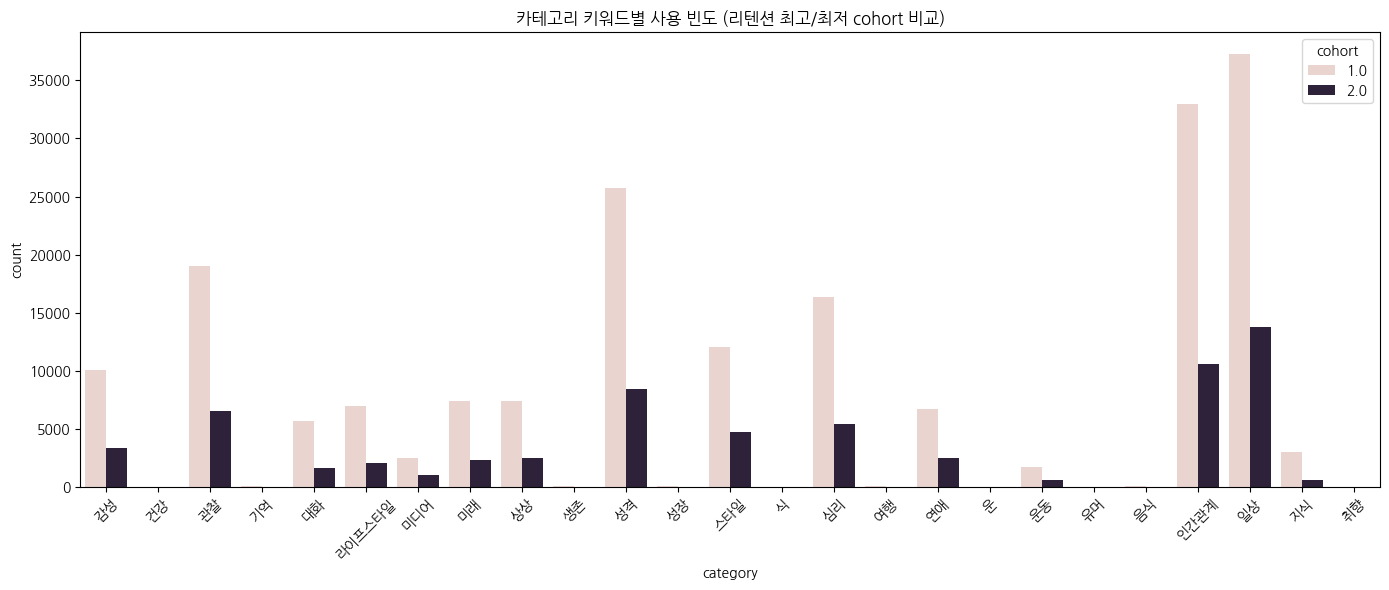

In [71]:
# 시각화
plt.figure(figsize=(14, 6))
sns.barplot(
    data=category_count_df,
    x='category',
    y='count',
    hue='cohort'
)
plt.xticks(rotation=45)
plt.title('카테고리 키워드별 사용 빈도 (리텐션 최고/최저 cohort 비교)')
plt.tight_layout()
plt.show()

- 각 코호트별 키워드 빈도수 내림차순

In [72]:
# 1번 집단
category_count_cohort1_df = category_count_df[category_count_df['cohort']==1]
# 키워드 내림차순
category_count_cohort1_df.sort_values(by='count', ascending=False)

,cohort,category,count
22,1.0,일상,37248
21,1.0,인간관계,32943
10,1.0,성격,25744
2,1.0,관찰,19069
14,1.0,심리,16386
12,1.0,스타일,12061
0,1.0,감성,10127
8,1.0,상상,7439
7,1.0,미래,7433
5,1.0,라이프스타일,6990


In [73]:
# 2번 집단
category_count_cohort2_df = category_count_df[category_count_df['cohort']==2]
# 키워드 내림차순
category_count_cohort2_df.sort_values(by='count', ascending=False)

,cohort,category,count
47,2.0,일상,13816
46,2.0,인간관계,10624
35,2.0,성격,8432
27,2.0,관찰,6595
39,2.0,심리,5464
37,2.0,스타일,4750
25,2.0,감성,3418
41,2.0,연애,2546
33,2.0,상상,2513
32,2.0,미래,2318


- 50% 기준으로 비교해보기

In [74]:
# 리텐션 최고/최저 그룹 나누기
# 일치하는게 없다면 결측값 처리하기

userquestionrecord_cohort_df['cohort'] = userquestionrecord_cohort_df['user_id'].apply(
    lambda x : 1 if x in user_upper50_list
    else (2 if x in user_lower50_list else np.nan)
)

# cohort가 결측값인 데이터 버리기
userquestionrecord_cohort_df = userquestionrecord_cohort_df[~userquestionrecord_cohort_df['cohort'].isna()]

# userquestionrecord_cohort_df와 polls_questionpiece_df 합치기
question_cohort_df = pd.merge(userquestionrecord_cohort_df, polls_questionpiece_df, left_on='question_piece_id', right_on='id', how='left')

# 필요없는 컬럼 날리기
question_cohort_df = question_cohort_df.drop(columns=['created_at_x', 'id', 'created_at_y'])

# question_category_df 와 합치기
question_category_cohort_df = pd.merge(question_cohort_df, question_category_df, left_on='question_id', right_on='id', how='left')

# category 컬럼이 리스트형태, explode로 키워드 분해
df_category_exploded = question_category_cohort_df.explode('category')

# 키워드 수 세기 (cohort별로)
category_count_df = df_category_exploded.groupby(['cohort', 'category']).size().reset_index(name='count')

# 1번 집단
category_count_cohort1_df = category_count_df[category_count_df['cohort']==1]
# 키워드 내림차순
category_count_cohort1_df.sort_values(by='count', ascending=False)

,cohort,category,count
22,1,일상,37248
21,1,인간관계,32943
10,1,성격,25744
2,1,관찰,19069
14,1,심리,16386
12,1,스타일,12061
0,1,감성,10127
8,1,상상,7439
7,1,미래,7433
5,1,라이프스타일,6990


In [75]:
# 2번 집단
category_count_cohort2_df = category_count_df[category_count_df['cohort']==2]
# 키워드 내림차순
category_count_cohort2_df.sort_values(by='count', ascending=False)

,cohort,category,count
47,2,일상,13816
46,2,인간관계,10624
35,2,성격,8432
27,2,관찰,6595
39,2,심리,5464
37,2,스타일,4750
25,2,감성,3418
41,2,연애,2546
33,2,상상,2513
32,2,미래,2318


---

### 집단별 구매율 차이

In [76]:
# 구매 기록 테이블
paymenthistory_df = pd.read_parquet('votes/accounts_paymenthistory.parquet') 
paymenthistory_df.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081


In [77]:
# user_0520_list 와 유저id가 일치하면 cohort라는 컬럼에 1을 넣고
# user_0517_list 와 유저id가 일치하면 cohort라는 컬럼에 2을 넣고
# 일치하는게 없다면 결측값 처리하기

paymenthistory_cohort_df = paymenthistory_df.copy()

paymenthistory_cohort_df['cohort'] = paymenthistory_cohort_df['user_id'].apply(
    lambda x : 1 if x in user_0509_list
    else (2 if x in user_0516_list else np.nan) 
    )

paymenthistory_cohort_df.head()

,id,productId,phone_type,created_at,user_id,cohort
0,6,heart.777,A,2023-05-13 21:28:34,1211127,NaN
1,7,heart.777,A,2023-05-13 21:29:39,1151343,NaN
2,8,heart.777,A,2023-05-13 21:31:33,1002147,NaN
3,9,heart.777,A,2023-05-13 21:31:39,1095040,NaN
4,11,heart.777,A,2023-05-13 21:34:32,1164081,NaN


In [78]:
# 결측값은 cohort 컬럼에만 있음
paymenthistory_cohort_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95140 entries, 0 to 95139
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          95140 non-null  int64         
 1   productId   95140 non-null  object        
 2   phone_type  95140 non-null  object        
 3   created_at  95140 non-null  datetime64[ns]
 4   user_id     95140 non-null  int64         
 5   cohort      34 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 4.4+ MB


In [79]:
# 결측값 제거
paymenthistory_cohort_df = paymenthistory_cohort_df.dropna()

# 날짜가 2023-05-01~25 일까지!!!
paymenthistory_cohort_df = paymenthistory_cohort_df[(paymenthistory_cohort_df['created_at']>='2023-04-28')&(paymenthistory_cohort_df['created_at']<'2023-05-26')]

# 구매율 구해보기

# 코호트별 수 구하기
paymenthistory_cohort_group_df = paymenthistory_cohort_df.groupby(['cohort']).size().reset_index(name='payment_count')
# 전체 코호트에서 비율 구하기
# user 리스트 길이
user_0509_count = len(user_0509_list)
user_0516_count = len(user_0516_list)

paymenthistory_cohort_group_df['payment_rate'] = paymenthistory_cohort_group_df.apply(
    lambda row : row['payment_count'] / user_0509_count if row['cohort'] == 1
    else (row['payment_count'] / user_0516_count if row['cohort'] == 2 else np.nan),
    axis=1
)

paymenthistory_cohort_group_df.head()

,cohort,payment_count,payment_rate
0,1.0,11,0.047619
1,2.0,12,0.100840


In [80]:
print(user_0509_count, user_0516_count)

231 119


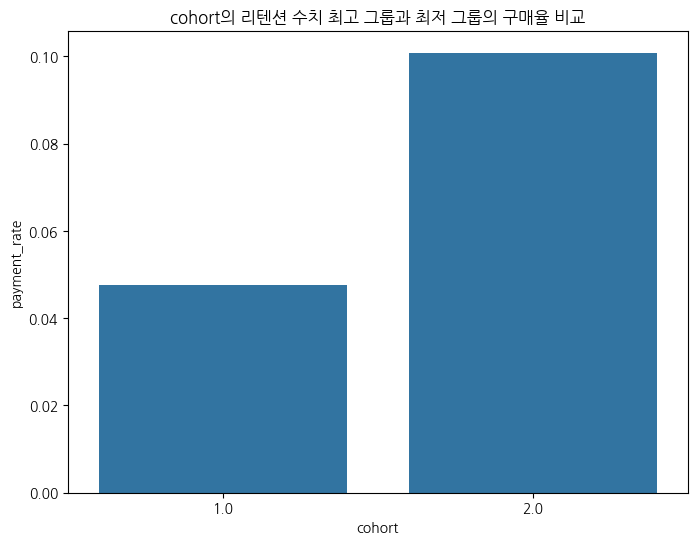

In [81]:
# 시각화
plt.figure(figsize=(8,6))
sns.barplot(data=paymenthistory_cohort_group_df, x='cohort', y='payment_rate')
plt.title('cohort의 리텐션 수치 최고 그룹과 최저 그룹의 구매율 비교')
plt.show()

- 50% 기준으로 그룹을 묶었을때도 차이가 있을까?

In [82]:
# 리텐션 50% 기준으로 그룹 나누기
# 일치하는게 없다면 결측값 처리하기

paymenthistory_cohort_df = paymenthistory_df.copy()

paymenthistory_cohort_df['cohort'] = paymenthistory_cohort_df['user_id'].apply(
    lambda x : 1 if x in user_upper50_list
    else (2 if x in user_lower50_list else np.nan) 
    )

paymenthistory_cohort_df.head()

,id,productId,phone_type,created_at,user_id,cohort
0,6,heart.777,A,2023-05-13 21:28:34,1211127,NaN
1,7,heart.777,A,2023-05-13 21:29:39,1151343,NaN
2,8,heart.777,A,2023-05-13 21:31:33,1002147,NaN
3,9,heart.777,A,2023-05-13 21:31:39,1095040,NaN
4,11,heart.777,A,2023-05-13 21:34:32,1164081,NaN


In [83]:
# 결측값 제거
paymenthistory_cohort_df = paymenthistory_cohort_df.dropna()

# 날짜가 2023-05-01~25 일까지!!!
paymenthistory_cohort_df = paymenthistory_cohort_df[(paymenthistory_cohort_df['created_at']>='2023-04-28')&(paymenthistory_cohort_df['created_at']<'2023-05-26')]

# 구매율 구해보기

# 코호트별 수 구하기
paymenthistory_cohort_group_df = paymenthistory_cohort_df.groupby(['cohort']).size().reset_index(name='payment_count')
# 전체 코호트에서 비율 구하기
# user 리스트 길이
user_upper_count = len(user_upper50_list)
user_lower_count = len(user_lower50_list)

paymenthistory_cohort_group_df['payment_rate'] = paymenthistory_cohort_group_df.apply(
    lambda row : row['payment_count'] / user_upper_count if row['cohort'] == 1
    else (row['payment_count'] / user_lower_count if row['cohort'] == 2 else np.nan),
    axis=1
)

paymenthistory_cohort_group_df.head()

,cohort,payment_count,payment_rate
0,1.0,188,0.102118
1,2.0,318,0.111111


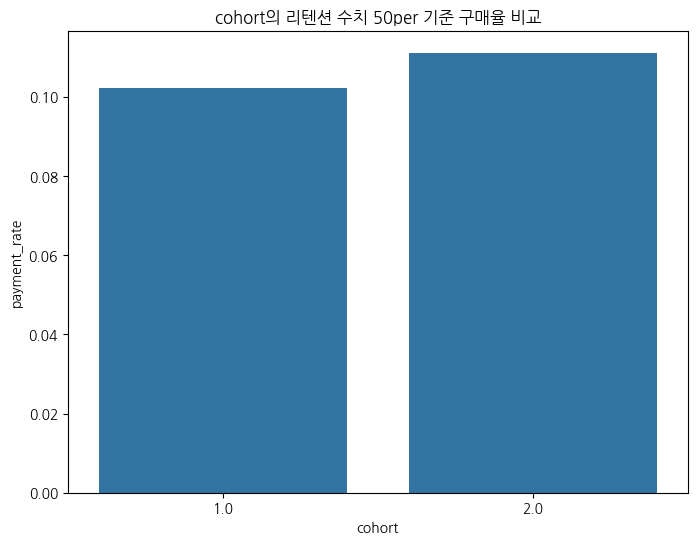

In [84]:
# 시각화
plt.figure(figsize=(8,6))
sns.barplot(data=paymenthistory_cohort_group_df, x='cohort', y='payment_rate')
plt.title('cohort의 리텐션 수치 50per 기준 구매율 비교')
plt.show()

- 두 번째로 높고, 낮은 그룹도 확인하기

In [85]:
# 리텐션 두 번째로 높고 낮은 그룹 확인하기
# 일치하는게 없다면 결측값 처리하기

paymenthistory_cohort_df = paymenthistory_df.copy()

paymenthistory_cohort_df['cohort'] = paymenthistory_cohort_df['user_id'].apply(
    lambda x : 1 if x in user_0520_list
    else (2 if x in user_0517_list else np.nan) 
    )

paymenthistory_cohort_df.head()

,id,productId,phone_type,created_at,user_id,cohort
0,6,heart.777,A,2023-05-13 21:28:34,1211127,NaN
1,7,heart.777,A,2023-05-13 21:29:39,1151343,NaN
2,8,heart.777,A,2023-05-13 21:31:33,1002147,NaN
3,9,heart.777,A,2023-05-13 21:31:39,1095040,NaN
4,11,heart.777,A,2023-05-13 21:34:32,1164081,NaN


In [86]:
# 결측값 제거
paymenthistory_cohort_df = paymenthistory_cohort_df.dropna()

# 날짜가 2023-05-01~25 일까지!!!
paymenthistory_cohort_df = paymenthistory_cohort_df[(paymenthistory_cohort_df['created_at']>='2023-04-28')&(paymenthistory_cohort_df['created_at']<'2023-05-26')]

# 구매율 구해보기

# 코호트별 수 구하기
paymenthistory_cohort_group_df = paymenthistory_cohort_df.groupby(['cohort']).size().reset_index(name='payment_count')
# 전체 코호트에서 비율 구하기
# user 리스트 길이
user_0520_count = len(user_0520_list)
user_0517_count = len(user_0517_list)

paymenthistory_cohort_group_df['payment_rate'] = paymenthistory_cohort_group_df.apply(
    lambda row : row['payment_count'] / user_0520_count if row['cohort'] == 1
    else (row['payment_count'] / user_0517_count if row['cohort'] == 2 else np.nan),
    axis=1
)

paymenthistory_cohort_group_df.head()

,cohort,payment_count,payment_rate
0,1.0,31,0.190184
1,2.0,16,0.231884


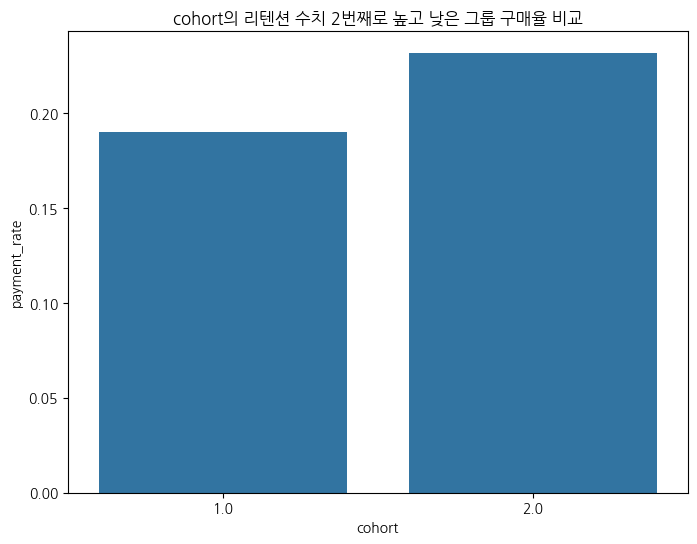

In [87]:
# 시각화
plt.figure(figsize=(8,6))
sns.barplot(data=paymenthistory_cohort_group_df, x='cohort', y='payment_rate')
plt.title('cohort의 리텐션 수치 2번째로 높고 낮은 그룹 구매율 비교')
plt.show()

---

### 이성에게 받은 투표 수 비교

- 그룹별, 나에게 투표해준 성별이 이성과 동성 중 어느쪽이 더 우세했는지 확인
    - 투표 받은 주요 성별의 수 / 전체 그룹 수
        - 투표 받은 주요 성벌 : 유저별 동성에게 받은 투표수랑 이성에게 받은 투표수 비교해서 더 우세했던 성별

In [88]:
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [89]:
# 투표 받은 기록에서 필요한 컬럼만 남기기
userquestionrecord_4567_df = userquestionrecord_df[['created_at', 'chosen_user_id', 'user_id']]

# 기간 자르기
userquestionrecord_4567_df = userquestionrecord_4567_df[(userquestionrecord_4567_df['created_at']>='2023-04-28')&(userquestionrecord_4567_df['created_at']<'2023-05-26')]

In [90]:
# 유저 성별 컬럼 확인
user_gender_df = user_df[['id', 'gender']]
user_gender_df.info()
# 2개의 결측치

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      677085 non-null  int64 
 1   gender  677083 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.3+ MB


In [91]:
# 성별 컬럼에서 결측치 제거
user_gender_df = user_gender_df[~user_gender_df['gender'].isna()]

In [92]:
# 투표 받은 기록에서 성별 넣어주기
 
# 매핑 딕셔너리 생성
id_to_gender = user_gender_df.set_index('id')['gender']

# chosen_user_id 기준으로 gender 매핑
userquestionrecord_4567_df['chosen_user_gender'] = userquestionrecord_4567_df['chosen_user_id'].map(id_to_gender)

# user_id 기준으로 gender 매핑
userquestionrecord_4567_df['user_gender'] = userquestionrecord_4567_df['user_id'].map(id_to_gender)

userquestionrecord_4567_df.head()

,created_at,chosen_user_id,user_id,chosen_user_gender,user_gender
0,2023-04-28 12:27:49,849469,849436,F,F
1,2023-04-28 12:28:02,849446,849436,F,F
2,2023-04-28 12:28:09,849454,849436,F,F
3,2023-04-28 12:28:16,847375,849436,F,F
4,2023-04-28 12:28:26,849477,849436,M,F


In [93]:
# 투표한 사람이 이성인지 동성인지 확인하기

userquestionrecord_4567_df['gender_match'] = userquestionrecord_4567_df.apply(
    lambda row: '동성' if row['chosen_user_gender'] == row['user_gender'] else '이성',
    axis=1
)

userquestionrecord_4567_df.head()

,created_at,chosen_user_id,user_id,chosen_user_gender,user_gender,gender_match
0,2023-04-28 12:27:49,849469,849436,F,F,동성
1,2023-04-28 12:28:02,849446,849436,F,F,동성
2,2023-04-28 12:28:09,849454,849436,F,F,동성
3,2023-04-28 12:28:16,847375,849436,F,F,동성
4,2023-04-28 12:28:26,849477,849436,M,F,이성


- 리텐션 min/max 그룹의 이성에게 투표받은 비율 구해보기

In [94]:
# 리텐션 max 그룹 확인하기

# 해당하는 유저 뽑기
chosen_0509_df = userquestionrecord_4567_df[userquestionrecord_4567_df['chosen_user_id'].isin(user_0509_list)]
chosen_0509_df.head()

,created_at,chosen_user_id,user_id,chosen_user_gender,user_gender,gender_match
163758,2023-05-06 06:38:44,894697,887600,M,F,이성
163994,2023-05-06 06:42:58,894697,885050,M,M,동성
166662,2023-05-06 07:40:10,894697,885050,M,M,동성
192544,2023-05-06 18:21:07,901012,918301,F,F,동성
192551,2023-05-06 18:22:01,901012,918301,F,F,동성


In [95]:
# 유저별 이성과 동성에게 받은 투표 수 뽑기
chosen_0509_df = chosen_0509_df.groupby(['chosen_user_id', 'gender_match']).size().unstack(fill_value=0)  # 열: '동성' '이성', 결측은 0
chosen_0509_df.head()

gender_match,동성,이성
chosen_user_id,,
841576,168,112
851523,56,13
853297,79,39
853305,132,79
853379,88,41


In [96]:
# 투표 받은 주요 성별

chosen_0509_df['main_gender'] = np.where(
    chosen_0509_df['동성'] > chosen_0509_df['이성'], '동성',
    np.where(chosen_0509_df['동성'] < chosen_0509_df['이성'], '이성', '동일')  # 동점 처리
)

chosen_0509_df.head()

gender_match,동성,이성,main_gender
chosen_user_id,,,
841576,168,112,동성
851523,56,13,동성
853297,79,39,동성
853305,132,79,동성
853379,88,41,동성


In [97]:
chosen_0509_df['main_gender'].value_counts()

main_gender
동성    217
이성     12
동일      2
Name: count, dtype: int64

```
이성에게 받은 비율 : 약 5%
```

In [98]:
# 리텐션 min 그룹 확인하기

# 해당하는 유저 뽑기
chosen_0516_df = userquestionrecord_4567_df[userquestionrecord_4567_df['chosen_user_id'].isin(user_0516_list)]

# 유저별 이성과 동성에게 받은 투표 수 뽑기
chosen_0516_df = chosen_0516_df.groupby(['chosen_user_id', 'gender_match']).size().unstack(fill_value=0)  # 열: '동성' '이성', 결측은 0

# 투표 받은 주요 성별

chosen_0516_df['main_gender'] = np.where(
    chosen_0516_df['동성'] > chosen_0516_df['이성'], '동성',
    np.where(chosen_0516_df['동성'] < chosen_0516_df['이성'], '이성', '동일')  # 동점 처리
)

# 뭐가 제일 많을까
chosen_0516_df['main_gender'].value_counts()

main_gender
동성    112
이성      6
동일      1
Name: count, dtype: int64

```
이성에게 받은 비율 : 약 5%
```

- 50% 로 확인하기

In [99]:
# 리텐션 upper50 그룹 확인하기

# 해당하는 유저 뽑기
chosen_upper50_df = userquestionrecord_4567_df[userquestionrecord_4567_df['chosen_user_id'].isin(user_upper50_list)]

# 유저별 이성과 동성에게 받은 투표 수 뽑기
chosen_upper50_df = chosen_upper50_df.groupby(['chosen_user_id', 'gender_match']).size().unstack(fill_value=0)  # 열: '동성' '이성', 결측은 0

# 투표 받은 주요 성별

chosen_upper50_df['main_gender'] = np.where(
    chosen_upper50_df['동성'] > chosen_upper50_df['이성'], '동성',
    np.where(chosen_upper50_df['동성'] < chosen_upper50_df['이성'], '이성', '동일')  # 동점 처리
)

# 뭐가 제일 많을까
chosen_upper50_df['main_gender'].value_counts()

main_gender
동성    1653
이성     178
동일       8
Name: count, dtype: int64

```
이성에게 받은 비율 : 약 9.7%
```

In [100]:
# 리텐션 lower50 그룹 확인하기

# 해당하는 유저 뽑기
chosen_lower50_df = userquestionrecord_4567_df[userquestionrecord_4567_df['chosen_user_id'].isin(user_lower50_list)]

# 유저별 이성과 동성에게 받은 투표 수 뽑기
chosen_lower50_df = chosen_lower50_df.groupby(['chosen_user_id', 'gender_match']).size().unstack(fill_value=0)  # 열: '동성' '이성', 결측은 0

# 투표 받은 주요 성별

chosen_lower50_df['main_gender'] = np.where(
    chosen_lower50_df['동성'] > chosen_lower50_df['이성'], '동성',
    np.where(chosen_lower50_df['동성'] < chosen_lower50_df['이성'], '이성', '동일')  # 동점 처리
)

# 뭐가 제일 많을까
chosen_lower50_df['main_gender'].value_counts()

main_gender
동성    2530
이성     297
동일      15
Name: count, dtype: int64

```
이성에게 받은 비율 : 약 10.5%
```